I've always found ROC curves a little confusing. Particularly when it comes to ROC curves with imbalanced classes. This blog post is an exploration into receiver operating characteristic (i.e. [roc](http://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html#sphx-glr-auto-examples-model-selection-plot-roc-py)) curves and how they react to imbalanced classes.

I start by loading the necessary libraries.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
%matplotlib inline

Seed the random number generator so that everything here is reproducible.

In [2]:
np.random.seed(seed=1)

I write a few functions that will create fake date, plot fake date, and plot roc curves. 

I describe each function in turn below:
 * **grab_probability** draws a sample of "probabilities" drawn from a uniform distribution bound between 0 and 1. 
 * **create_fake_binary_data** creates a vector of 0s and 1s. The mean of the vector is controlled by the positive input.
 * **probability_hist** plots a normalized histogram (each bar depicts the proportion of data in it) bound between 0 and 1.
 * **plot_roc_curve** does not need an explanation

In [3]:
def grab_probability(sample_size):
    """Draw probabilties"""
    return np.random.random(size=(sample_size,))
    
def create_fake_binary_data(positive, sample_size):
    """Create a vector of binary data with the mean specified in positive"""
    negative = 1-positive
    y = np.ones(sample_size)
    y[:int(negative*sample_size)] = 0
    np.random.shuffle(y)
    return y
    
def probability_hist(probs):
    """Create histogram of probabilities"""
    fig = plt.Figure()
    weights = np.ones_like(probs)/float(len(probs))
    plt.hist(probs, weights=weights)
    plt.xlim(0, 1)
    plt.ylim(0, 1);
    
def plot_roc_curve(fpr, tpr, roc_auc, lw=2):
    """Plot roc curve"""
    lw = lw
    fig = plt.Figure()
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right");

I have found one of the best ways to learn about an algorithm is to give it fake data. That way, I know the data, and can examine exactly what the algorithm does with the data. I then change the data and examine how the algorithm reacts to this change.

The first dataset I create is random data with balanced classes. 

I create *probability* with the grab_probability function. This is a vector of number between 0 and 1. These data are meant to simulate the probabilities that would be produced by a model that is no better than chance.

I also create the vector *y* that I created above are random ones and zeroes. I will call the ones the positive class and the zeroes the negative class.

The plot below is a histogram. The y-axis is the proprotion of samples in each bin. The x-axis is probability levels. You can see the probabilities appear to be from a uniform distribution.

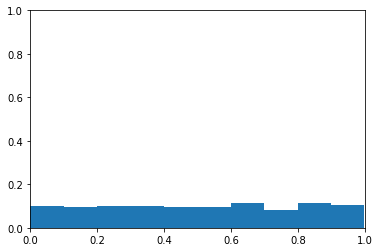

In [4]:
sample_size = 1000
positive = 0.5

y = create_fake_binary_data(positive, sample_size)
probability = grab_probability(sample_size)

probability_hist(probability)

There's no association between *y* and the *probability*, so I don't expect the area under the curve to be different than chance (i.e., have an area under the curve of about 0.5). I plot the roc curve to confirm this below.

Let's talk about the axes here. The y-axis is the proportion of true positives (i.e., [TPR](https://en.wikipedia.org/wiki/Sensitivity_and_specificity) - True Positive Rate). This is how often the model correctly identifies members of the positive class. The x-axis is the proportion of false positives (FPR - False Positive Rate). This how often the model incorrectly assigns examples to the positive class.

One might wonder how the TPR and FPR can change. Doesn't a model always produce the same guesses? The TPR and FPR can change because we can choose how liberal or conservative the model should be when assigning exemplars to the positive class. The lower left-hand corner of the plot below is when the model is maximally conservative (and assigns no examples to the positive class). If the model never guesses that any examples are from the positive class, then it's TPR and FPR will both be 0. The upper right-hand corner is when the model is maximally liberal and assigns every example to the positive class. If a model guesses guesses that all examples are from the postive class then both the TPR and FRP will be 1. 

I think on of the most confusing parts of the ROC curves is I used to assume that when a model is neutral in assigning an exemplar to the positive class, that point would like halfway between the end points, but this is not the case. The threshold creates points along the curve, but doesn't dictate where these points lie. If this point is confusing, continue to think about it as we march through the proceeding plots.

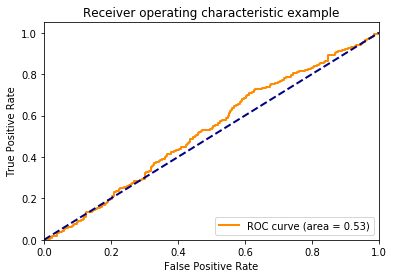

In [5]:
fpr, tpr, thresholds = roc_curve(y, probability)
roc_auc = auc(fpr, tpr)

plot_roc_curve(fpr, tpr, roc_auc)

The roc curve is the balance between true and false positives as a threshold varies. To help visualize how this balance, I plot out the two classes as a stacked histogram, a cumulative density function of the data,  and the relative balance between the two classes.

In [6]:
def probability_histogram_class(probability, y):
    plt.subplot(221)
    counts, bins, _ = plt.hist([probability[y==0], probability[y==1]], stacked=True)
    plt.xlim(np.min(bins),np.max(bins))
    plt.xticks([])
    
    plt.subplot(222)
    plt.hist(probability[y==1], cumulative=True, normed=True, color='tab:orange')
    plt.xlim(np.min(bins),np.max(bins))
    plt.xticks([])
    plt.ylim(0,1)
    
    plt.subplot(224)
    plt.hist(probability[y==0], cumulative=True, normed=True, color='tab:blue')
    plt.xlim(np.min(bins),np.max(bins))
    plt.xticks()
    plt.ylim(0,1)
    
    plt.subplot(223)
    proportion = counts[0]/[max(0.0001, x) for x in counts[1]]
    plt.plot(bins[:-1], 1-proportion)
    plt.xlim(np.min(bins),np.max(bins))
    plt.ylim(0,1);

The idea behind the plots is we can visualize the threshold moving from LEFT to RIGHT throgh the plots. As the threshold decreases, the model will guess the positive class more often. This means more and more of each class will be included when calculating the TPR and FPR.

The top left plot is a stacked histogram. Orange depicts members of the positive class and blue depicts members of the negative class. On the x-axis (of all four plots) probability.

If we continue thinking about the threshold as decreasing as the plots moves from left to right, we can think of the top right plot ([cdf](https://en.wikipedia.org/wiki/Cumulative_distribution_function) of the positive class) as depicting the proportion of the positive class assigned to the positive class as the threshold varies (setting the TPR). We can think of the bottom right plot (cdf of the negative class) as depicting the proportion of the negative class assigned to the positive class as the threshold varies (setting the FPR).

In the bottom left plot, I plot the proportion of positive class that falls in each bin from the histogram in the top plot.  Because the proportion of positive and negative class are equal as the threshold varies (as depicted in the bottom plot) we consistently assign both positive and negative examples to the positive class at equal rates and the roc stays along the identity and the area under the curve is 0.5. 

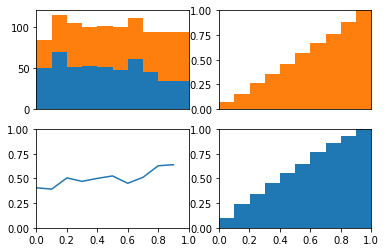

In [7]:
probability = grab_probability(sample_size)

probability_histogram_class(probability, y)

Next, I do the same process as above but with fake probabilities that are predictive of the label. The function biased_probability produces probabilities that tend to be greater for the positive class and lesser for the negative class.

In [8]:
def biased_probability(y):
    """Return probabilities biased towards correct answer"""
    probability = np.random.random(size=(len(y),))
    probability[y==1] = np.random.random(size=(int(sum(y)),)) + 0.25
    probability[y==0] = np.random.random(size=(int(sum(y==0)),)) - 0.25
    probability = np.array([max(0, min(1, i)) for i in probability])
    return probability

I create this data for a balanced class problem again. using the same y vector, I adjust the probabilities so that they are predcitive of the values in this y vector. Below, you can see the data as a histogram. The data no longer appear to be drawn from a uniform distribution. Instead there are modes near 0 and 1.

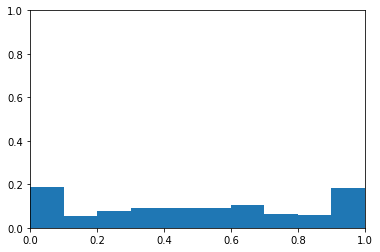

In [9]:
probability = biased_probability(y)

probability_hist(probability)

Now, we get a nice roc curve which leaves the identity line. Not surprising since I designed the data probabilities to be predictive. Notice how quickly the model acheives a TPR of 1. Remember this when looking at the plots below.

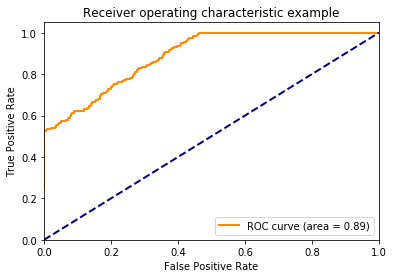

In [10]:
fpr, tpr, _ = roc_curve(y, probability)
roc_auc = auc(fpr, tpr)

plot_roc_curve(fpr, tpr, roc_auc)

In the upper left plot below, we can clearly see that the positive class occurs more often than the negative class on the right side of the plot. 

Now remember that the lower left hand side of the roc plot is when we are most conservative. This corresponds to the right hand side of these plots where the model is confident that these examples are from the positive class.

If we look at the cdfs of left side. We can see the positive class (in orange) has many examples on the right side of these plots while the negative class (in blue) has no examples on this side. This is why the TPR immediately jumps to about 0.5 in the roc curve above. We also see the positive class has no examples on the left side of these plots while the negative class has many. This is why the TPR saturates at 1 well before the FPR does.

In other words, because there model is quite certain that some examples are from the positive class the ROC curve quickly jumps up on the y-axis. Because the model is quite certain as to which examples are from the negative class, the ROC curves saturates on the y-axis well before the end of the x-axis.

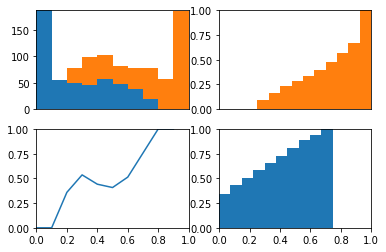

In [11]:
probability = biased_probability(y)

probability_histogram_class(probability, y)

After those two examples, I think we have a good handle on the ROC curve in the balanced class situation. Now let's make some fake data when the classes are unbalanced. The probabilities will be completely random. 

Average Test Value: 0.70
Average Probability: 0.49


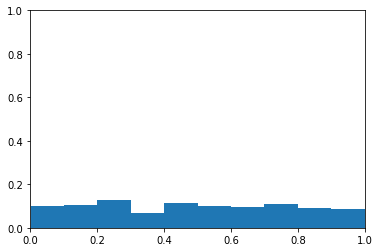

In [12]:
sample_size = 1000
positive = 0.7

y = create_fake_binary_data(positive, sample_size)
probability = grab_probability(sample_size)

print('Average Test Value: %0.2f' % np.mean(y))
print('Average Probability: %0.2f' % np.mean(probability))

probability_hist(probability)

Again, this is fake data, so the probabilities do not reflect the fact that the classes are imbalanced. 

Below, we can see that the ROC curve agrees that the data are completely random.

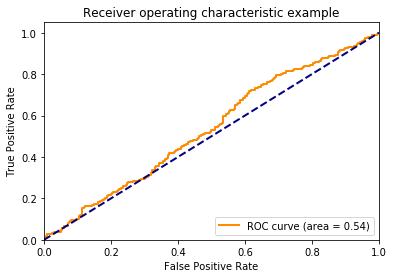

In [13]:
fpr, tpr, _ = roc_curve(y, probability)
roc_auc = auc(fpr, tpr)

plot_roc_curve(fpr, tpr, roc_auc)

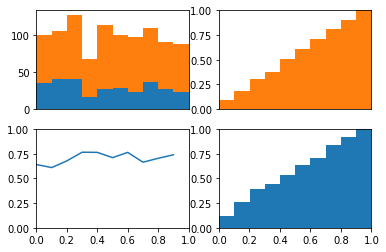

In [14]:
probability_histogram_class(probability, y)

Now, lets create biased probabilities and see if the ROC curve differs from chance

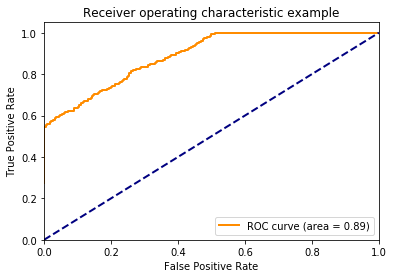

In [15]:
from sklearn.utils import shuffle

probability = biased_probability(y)

fpr, tpr, _ = roc_curve(y, probability)
roc_auc = auc(fpr, tpr)

plot_roc_curve(fpr, tpr, roc_auc)

It does as we expect.

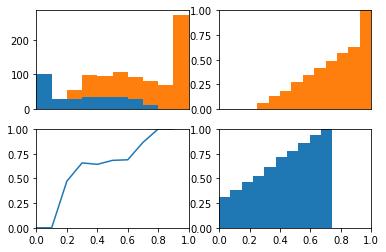

In [16]:
probability_histogram_class(probability, y)

Importantly, the probabilities now reflect the biased classes

In [17]:
print(np.mean(probability))

0.602536255717


Using these same probabilities, lets remove the relationship between the probabilities and the output variable by shuffling the data.

In [18]:
y = shuffle(y)

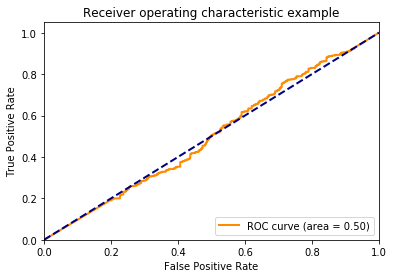

In [19]:
fpr, tpr, _ = roc_curve(y, probability)
roc_auc = auc(fpr, tpr)

plot_roc_curve(fpr, tpr, roc_auc)

Beautiful! the ROC curve stays on the identity line. We can see that this is because while the positive class is predicted more often, the positive class is evently distributed across the different thresholds. 

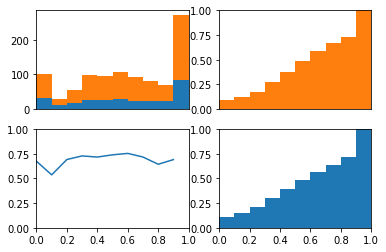

In [20]:
probability_histogram_class(probability, y)

Importantly, this demonstrates that even with imbalanced classes, if a model is at chance, then the ROC curve will reflect this chance perforomance. I do a similar demonstration with fake data [here](www.hidan.com).

In [21]:
%load_ext watermark
%watermark -v -m -p numpy,matplotlib,sklearn

CPython 3.6.3
IPython 6.1.0

numpy 1.13.3
matplotlib 2.0.2
sklearn 0.19.1

compiler   : GCC 7.2.0
system     : Linux
release    : 4.13.0-36-generic
machine    : x86_64
processor  : x86_64
CPU cores  : 4
interpreter: 64bit
